In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
%matplotlib inline

from keras.layers import Input,Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K


Using TensorFlow backend.


# Data read directly instead of pickling

In [2]:
#train_data = pd.read_csv('../../SDCND_BehaviouralCloning/data/data/driving_log.csv')

path = '../../SDCND_BehaviouralCloning/data/data/'
train_data = pd.read_csv(path+'driving_log.csv')
X_center = train_data['center'].as_matrix()
X_left =  train_data['left'].as_matrix()
X_right = train_data['right'].as_matrix()
y_train = train_data['steering'].as_matrix()





In [3]:
### routines
#Brightness adjustment
def brightness_adjust_image(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

#Flipping
def flip(camera,image,steering):
    if camera == 'center':
        image=cv2.flip(image,1)
        steering = -steering
    #else:
        #print('only center camera images to be flipped')
    return image, steering




In [4]:
### Read image routine
import random

def read_image(r,camera,X_center,X_left,X_right,y_train):
    ### r is the index of image from  .csv file 
    steering = y_train[r]
    #print('org_steering :',steering)
    
    if camera =='center':
        image = mpimg.imread(path+X_center[r].strip())
    elif camera == 'left':
        image = mpimg.imread(path+X_left[r].strip())
        steering += 0.25
    elif camera == 'right':
        image = mpimg.imread(path+X_right[r].strip())
        steering -=0.25
    return image,steering,camera
        


In [5]:
### Preprocess
### Resize to 32x16
def resize(image,size):
    img = cv2.resize(image,size)
    return img

def RGB_HSV_S(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    return img

7600
camera: center
recovery steering: 0.0
flipped steering: -0.0


(-0.5, 31.5, 15.5, -0.5)

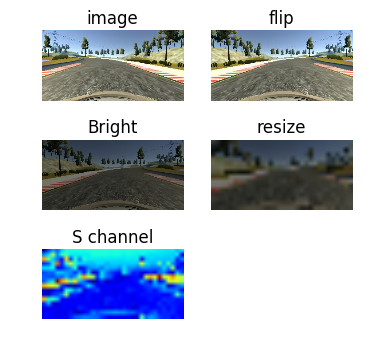

In [6]:
# sample read and plot
r = random.randint(0,len(y_train))
camera = random.choice(['center','left','right'])
image,steering,camera = read_image(r,camera,X_center,X_left,X_right,y_train)

fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(3,2,1)
ax.set_title('image')
plt.imshow(image)
plt.axis('off')
print(r)
print('camera:',camera)
print('recovery steering:',steering)
### flipping center camera image
image,steering = flip(camera,image,steering)
ax=fig.add_subplot(3,2,2)
ax.set_title('flip')
plt.imshow(image)
plt.axis('off')
print('flipped steering:',steering)
 
### Brightness adjustment
image = brightness_adjust_image(image)
ax=fig.add_subplot(3,2,3)
ax.set_title('Bright')
plt.imshow(image)
plt.axis('off')

### Preprocess
### Resize to 32x16
def resize(image,size):
    img = cv2.resize(image,size)
    return img
image = resize(image,(32,16))
ax=fig.add_subplot(3,2,4)
ax.set_title('resize')
plt.imshow(image)
plt.axis('off')

def RGB_HSV_S(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    return img

image = RGB_HSV_S(image)
ax=fig.add_subplot(3,2,5)
ax.set_title('S channel')
plt.imshow(image)

plt.axis('off')


In [7]:
### Generator
batch_size = 128
batch_images = np.zeros((batch_size, 16, 32 ,1))
batch_steering = np.zeros(batch_size)
def generate_train_dataset(X_center,X_left,X_right,y_train,batch_size):
    while 1:
        for i in range(batch_size):
            r = np.random.randint(0,len(y_train))
            camera = np.random.choice(['center','left','right'])
            image,steering,camera = read_image(r,camera,X_center,X_left,X_right,y_train)
        
            ### flipping center camera image
            image,steering = flip(camera,image,steering)
        
            ### Brightness adjustment
            image = brightness_adjust_image(image)
        
            ### Preprocess
            ### Resize to 32x16
            image = resize(image,(32,16))
            ### RGB to HSV to S channel
            image = RGB_HSV_S(image)
        
               
            batch_images[i] = image.reshape(16,32,1)
            batch_steering[i] = steering
                      
        yield batch_images,batch_steering
    
train_generator =   generate_train_dataset(X_center,X_left,X_right,y_train,batch_size) 


In [8]:
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU

ch , row, col =  1, 16, 32  # camera format

model = Sequential() 

model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=( row, col, ch),output_shape=(row, col,ch)))
model.add(Convolution2D(12, 3, 3, border_mode="valid"))
model.add(ELU())
model.add(MaxPooling2D((4,4),(4,4),'valid'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

history = model.fit_generator(train_generator,samples_per_epoch=10112, nb_epoch=15)
model.summary()

Epoch 1/15
10112/10112 [==============================] - 236s - loss: 0.1214   
Epoch 2/15
10112/10112 [==============================] - 167s - loss: 0.0625   
Epoch 3/15
10112/10112 [==============================] - 124s - loss: 0.0459   
Epoch 4/15
10112/10112 [==============================] - 96s - loss: 0.0391    
Epoch 5/15
10112/10112 [==============================] - 74s - loss: 0.0342    
Epoch 6/15
10112/10112 [==============================] - 63s - loss: 0.0331    
Epoch 7/15
10112/10112 [==============================] - 53s - loss: 0.0319    
Epoch 8/15
10112/10112 [==============================] - 48s - loss: 0.0304    
Epoch 9/15
10112/10112 [==============================] - 47s - loss: 0.0289    
Epoch 10/15
10112/10112 [==============================] - 45s - loss: 0.0294    
Epoch 11/15
10112/10112 [==============================] - 45s - loss: 0.0277    
Epoch 12/15
10112/10112 [==============================] - 43s - loss: 0.0274    
Epoch 13/15
10112/10112 [

In [9]:

model_json = model.to_json()
with open("model_generator.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_generator.h5")
print("Saved model to disk")

Saved model to disk
